# A notebook for empirical work on the `libData.csv` peer effects data

This cell sets up the notebook to import numpy, datetime, seaborn, pandas, matplotlib etc.

In [1]:
# Run this cell to set up the notebook.

# These lines import the Numpy, Datascience, pandas modules.
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import datetime as datetime
import random
import matplotlib
import matplotlib.pyplot as plt

# Importing plotting libraries and styles
%matplotlib inline
plt.style.use('fivethirtyeight')

# For Pandas to ignore FutureWarning displays
import warnings
warnings.simplefilter('ignore', FutureWarning)

## Summary Statistics

The function below computes summary statistics.

**Format:** Identity, Person, Table, Library, Arrival Time, Departure Time, Num Breaks, Break Start Times (list), Break End Times (list), fromStart, tillEnd, Neighbors, Known, yourName, yourTable, yourSeat

* Average duration of stay (percentiles as well) DONE
* Average number of breaks DONE
* Average duration of break DONE
* Average work-time between breaks (frequency of breaks) todo: compute on paper DONE
* Average number of neighbors DONE
* Number of people per library DONE
* Number of people there fromStart DONE
* Number of people there tillEnd DONE

In [2]:
libData = pd.read_csv('libDataTest.csv')
libData

,ID,Person,Table,Library,Arrival,Departure,Num_Breaks,Break_Start,Break_End,fromStart,tillEnd,Neighbors,Known,yourName,yourTable,yourSeat
0,5657,2,A,Moffit,2019-03-23 18:20:02.703347,2019-03-23 18:33:47.097748,0,[],[],0,0,"[(5, 7808)]",[],Max,B,2
1,7808,5,A,Moffit,2019-03-23 18:20:02.705239,2019-03-23 18:42:29.331629,1,"[datetime.datetime(2019, 3, 23, 18, 20, 3, 781...","[datetime.datetime(2019, 3, 23, 18, 30, 23, 76...",0,1,"[(2, 5657)]",[],Max,B,2
2,7657,1,B,Stacks,2019-03-23 18:25:41.342617,2019-03-23 18:37:07.846707,1,"[datetime.datetime(2019, 3, 23, 18, 27, 36, 35...","[datetime.datetime(2019, 3, 23, 18, 37, 7, 846...",1,0,"[(3, 7477), (6, 6146)]","[(3, 7477), (6, 6146)]",Max,B,2
3,7477,3,B,Stacks,2019-03-23 18:27:35.896722,2019-03-23 18:42:29.331629,2,"[datetime.datetime(2019, 3, 23, 18, 27, 36, 35...","[datetime.datetime(2019, 3, 23, 18, 37, 7, 846...",0,1,"[(1, 7657), (6, 6146)]","[(1, 7657)]",Max,B,2
4,6146,6,B,Stacks,2019-03-23 18:34:10.473014,2019-03-23 18:42:29.331629,0,[],[],0,1,"[(1, 7657), (3, 7477)]","[(1, 7657)]",Max,B,2


In [3]:
# This function takes in the libData.csv dataframe and outputs some summary statistics about the data.

def summaryStats(libData):
    libStats = pd.DataFrame()
    departureDatetime = libData["Departure"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
    arrivalDatetime = libData["Arrival"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
    duration = (departureDatetime - arrivalDatetime).apply(datetime.timedelta.total_seconds)
    libStats['duration'] = duration
    libStats['num_breaks'] = libData["Num_Breaks"]
    libStats['fromStart'] = libData["fromStart"]
    libStats['tillEnd'] = libData["tillEnd"]
    libStats['num_neighbors'] = libData["Neighbors"].apply(eval).apply(len)
    libStats['known'] = libData["Known"].apply(eval).apply(len)
    
    # Maximum number of breaks for each person
    maxBreaks = libData["Break_End"].apply(lambda x: eval(x)).apply(len)
    breakEnds = libData["Break_End"].apply(lambda x: eval(x))
    breakStarts = libData["Break_Start"].apply(lambda x: eval(x))
    
    # Array of average durations for each row which will be appended into libStats
    breakDurationArray = []
    
    for rowIndex in range(len(libData)):
        avgDuration = []
        for breakIndex in range(maxBreaks[rowIndex]):
            breakDuration = breakEnds[rowIndex][breakIndex] - breakStarts[rowIndex][breakIndex]
            avgDuration.append(breakDuration.total_seconds())
        breakDurationArray.append(np.mean(avgDuration))
    
    libStats['average_break_duration'] = breakDurationArray
    
    # Computing average duration between break
    betweenBreakDuration = []
    # Required array of start breaks
    maxStartBreaks = libData["Break_Start"].apply(lambda x: eval(x)).apply(len)
    
    for rowIndex in range(len(libData)):
        avgBetweenDuration = []
        
        # Including the time from arrival to breakStart
        if len(breakStarts[rowIndex])>0:
            avgBetweenDuration.append((breakStarts[rowIndex][0] - arrivalDatetime[rowIndex]).total_seconds())
        
        for j in range(1, maxStartBreaks[rowIndex]):
            # Adding the difference between new breakStart time and old breakEnd time
            avgBetweenDuration.append((breakStarts[rowIndex][j] - breakEnds[rowIndex][j-1]).total_seconds())
            
        betweenBreakDuration.append(np.mean(avgBetweenDuration))
    
    libStats['time_between_breaks'] = betweenBreakDuration
    
    print("Number of people who were there at the start:", np.count_nonzero(libData["fromStart"]))
    print("Number of people who stayed till the end:", np.count_nonzero(libData["tillEnd"]))
    peoplePerLibrary = libData.groupby("Library").count()["Person"]
    
    for i in peoplePerLibrary.index:
        print("Number of people in "+ i + " is: " + str(peoplePerLibrary[i]))
    
    return libStats.describe()

In [4]:
summaryStats(libData)

Number of people who were there at the start: 1
Number of people who stayed till the end: 3
Number of people in Moffit is: 2
Number of people in Stacks is: 3


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,duration,num_breaks,fromStart,tillEnd,num_neighbors,known,average_break_duration,time_between_breaks
count,5.000000,5.00000,5.000000,5.000000,5.000000,5.00000,3.000000,3.000000
mean,849.963681,0.80000,0.200000,0.600000,1.600000,0.80000,540.731824,111.198526
std,315.915807,0.83666,0.447214,0.547723,0.547723,0.83666,98.322381,93.339332
min,498.858615,0.00000,0.000000,0.000000,1.000000,0.00000,430.707386,16.010014
25%,686.504090,0.00000,0.000000,0.000000,1.000000,0.00000,501.098699,65.511952
50%,824.394401,1.00000,0.000000,1.000000,2.000000,1.00000,571.490012,115.013889
75%,893.434907,1.00000,0.000000,1.000000,2.000000,1.00000,595.744042,158.792781
max,1346.626390,2.00000,1.000000,1.000000,2.000000,2.00000,619.998073,202.571674


In [5]:
libData

,ID,Person,Table,Library,Arrival,Departure,Num_Breaks,Break_Start,Break_End,fromStart,tillEnd,Neighbors,Known,yourName,yourTable,yourSeat
0,5657,2,A,Moffit,2019-03-23 18:20:02.703347,2019-03-23 18:33:47.097748,0,[],[],0,0,"[(5, 7808)]",[],Max,B,2
1,7808,5,A,Moffit,2019-03-23 18:20:02.705239,2019-03-23 18:42:29.331629,1,"[datetime.datetime(2019, 3, 23, 18, 20, 3, 781...","[datetime.datetime(2019, 3, 23, 18, 30, 23, 76...",0,1,"[(2, 5657)]",[],Max,B,2
2,7657,1,B,Stacks,2019-03-23 18:25:41.342617,2019-03-23 18:37:07.846707,1,"[datetime.datetime(2019, 3, 23, 18, 27, 36, 35...","[datetime.datetime(2019, 3, 23, 18, 37, 7, 846...",1,0,"[(3, 7477), (6, 6146)]","[(3, 7477), (6, 6146)]",Max,B,2
3,7477,3,B,Stacks,2019-03-23 18:27:35.896722,2019-03-23 18:42:29.331629,2,"[datetime.datetime(2019, 3, 23, 18, 27, 36, 35...","[datetime.datetime(2019, 3, 23, 18, 37, 7, 846...",0,1,"[(1, 7657), (6, 6146)]","[(1, 7657)]",Max,B,2
4,6146,6,B,Stacks,2019-03-23 18:34:10.473014,2019-03-23 18:42:29.331629,0,[],[],0,1,"[(1, 7657), (3, 7477)]","[(1, 7657)]",Max,B,2


## Simulated pairs vs actual pairs hypothesis test - confidence interval

In [6]:
def bootStrap(libData, statistic_fn, num_repetitions, startTime=None, endTime=None, libraryName=None):
    """ A function to perform the bootstrap of libData and compute a distribution based on actual, sampled pairs.
    
    libData: Our library_data dataframe loaded in Pandas
    statistic_fn: The test_statistic that we want to compute: eg. difference in leaving times of two pairs
    num_repetitions: The number of repetitions that you want to compute the bootstrap
    
    Note: startTime, endTime, libraryName filtering not implemented yet.
    """
    idSeries = libData['ID']
    tableSeries = libData['Table']
    libName = libData['Library']
    neighbourSeries = libData["Neighbors"].apply(lambda x: eval(x))
    
    actual_pairs = []
    
    for i in np.arange(len(idSeries)):
        for tpl in neighbourSeries[i]:
            # Add sorted tuples only to the set
            sortedTpl = tuple(sorted((idSeries[i], tpl[1])))
            if sortedTpl not in actual_pairs:
                actual_pairs.append(sortedTpl)
        
    n = len(actual_pairs)
    
    # Observed value of the test statistic
    actual_avg_difference = statistic_fn(actual_pairs)
    
    # Array to store the test statistics
    test_stats = np.array([])
    
    # random.sample(idSeries, n) is without_replacement
    # random.choice(idSeries) is with_replacement
    for i in np.arange(num_repetitions):
        z1 = [random.choice(idSeries) for _ in range(n)]
        z2 = [random.choice(idSeries) for _ in range(n)]
        sampled_pairs = list(zip(z1, z2))

        # For each pair, calculate some statistic such as difference in leaving times 
        sampled_avg_difference = statistic_fn(sampled_pairs)
        
        # Append this back to test_stats
        test_stats = np.append(test_stats, sampled_avg_difference)
    
    # 95% confidence interval
    left = np.percentile(test_stats, 2.5)
    right = np.percentile(test_stats, 97.5)
    print("95% Confidence Interval is", (left, right))
    print("Observed value (in actual pairs) is", actual_avg_difference)
    
    plt.hist(test_stats)
    plt.plot([left, right], [0, 0], color='yellow', lw=3, zorder=1)
    
    # Observed value statistic on actual_pairs
    plt.scatter(actual_avg_difference, 0, color='red', s=30, zorder=2)
    
    return

In [7]:
def difference_in_leaving_times(pairs):
    departureDatetime = libData["Departure"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
    
    differences = []
    for tpl in pairs:
        # Finding index in dataframe based on ID
        leaving_time_0_index = libData[libData["ID"]==tpl[0]].index[0]
        leaving_time_1_index = libData[libData["ID"]==tpl[1]].index[0]
        # Finding the difference in leaving times
        time_diff = departureDatetime[leaving_time_0_index] - departureDatetime[leaving_time_1_index]
        differences.append(abs(time_diff.total_seconds()))
    
    return np.mean(differences)

In [8]:
def difference_in_arrival_times(pairs):
    arrivalDatetime = libData["Arrival"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
    
    differences = []
    for tpl in pairs:
        # Finding index in dataframe based on ID
        arrival_time_0_index = libData[libData["ID"]==tpl[0]].index[0]
        arrival_time_1_index = libData[libData["ID"]==tpl[1]].index[0]
        # Finding the difference in arrival times
        time_diff = arrivalDatetime[arrival_time_0_index] - arrivalDatetime[arrival_time_1_index]
        differences.append(abs(time_diff.total_seconds()))
        
    return np.mean(differences)

In [9]:
def difference_in_num_breaks(pairs):
    numBreaks = libData["Num_Breaks"]
    
    differences = []
    
    for tpl in pairs:
        # Finding index in dataframe based on ID
        break_0_index = libData[libData["ID"]==tpl[0]].index[0]
        break_1_index = libData[libData["ID"]==tpl[1]].index[0]
        # Finding the difference in number of breaks
        n_diff = numBreaks[break_0_index] - numBreaks[break_1_index]
        differences.append(abs(n_diff))
    
    return np.mean(differences)

95% Confidence Interval is (0.0, 441.8626505)
Observed value (in actual pairs) is 291.30093124999996


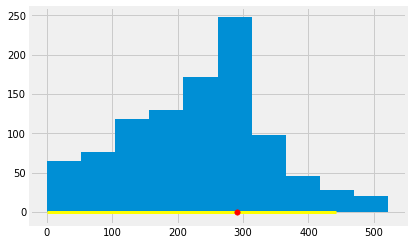

In [10]:
bootStrap(libData, difference_in_leaving_times, 1000)

95% Confidence Interval is (112.93154945625002, 635.82677725)
Observed value (in actual pairs) is 254.5656715


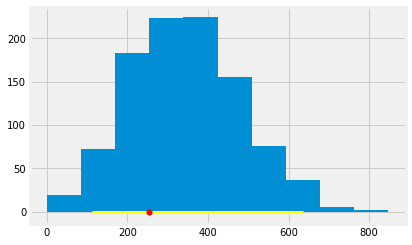

In [11]:
bootStrap(libData, difference_in_arrival_times, 1000)

95% Confidence Interval is (0.25, 1.5)
Observed value (in actual pairs) is 1.25


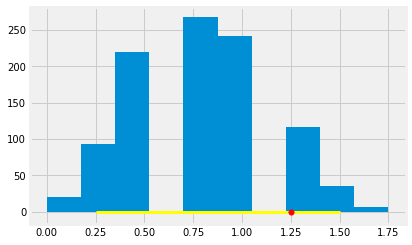

In [12]:
bootStrap(libData, difference_in_num_breaks, 1000)

## Model of test

In [13]:
k3gi02 = stats.uniform.rvs(0,120,5)
k3gi02

array([ 53.91435551,  14.02227771,  48.19836798, 112.61320383,
        65.25055802])

In [14]:
dt702 = datetime.datetime.strptime("01/01/19 19:00", "%d/%m/%y %H:%M")
#datetime.timedelta(minutes = k3gi02)
cool23rs = lambda x: datetime.timedelta(minutes = x)
#pop190 = 
pop190 + dt702

NameError: name 'pop190' is not defined

In [ ]:
dkeys = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
len(list(dkeys) + \
"A1 B1 C1 D1 E1 F1 G1 H1 I1 J1 K1 L1 M1 N1".split(" "))

In [ ]:
dictionaryKeys = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + \
                "A1 B1 C1 D1 E1 F1 G1 H1 I1 J1 K1 L1 M1 N1".split(" ")
    
keyProbs = {dictionaryKeys[i]: 1.0 for i in range(40)}
keyProbs


In [ ]:
len(list(keyProbs.keys())*8)

In [ ]:
pk = (0.1, 0.2, 0.3, 0.1, 0.1, 0.0, 0.2)
custm = stats.rv_discrete(name='custm', values=(list(keyProbs.keys()), list(keyProbs.values())))

In [ ]:
np.random.choice(list(keyProbs.keys()), list(keyProbs.values()))

In [ ]:
def generateModelData():
    # Using 01/01/2019 as our starting date
    simLibData = pd.DataFrame()
    startTime = dt702 = datetime.datetime.strptime("01/01/19 19:00", "%d/%m/%y %H:%M")
    
    arrival_times_delta = stats.uniform.rvs(0,120,200)
    convertToTimeDelta = np.array([datetime.timedelta(minutes = x) for x in arrival_times_delta])
    
    arrival_times = startTime + convertToTimeDelta
    simLibData['Arrival'] = arrival_times
    
    dictionaryKeys = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + \
                    "A1 B1 C1 D1 E1 F1 G1 H1 I1 J1 K1 L1 M1 N1".split(" ")
    dictionaryValues = [[1, 2, 3, 4, 5, 6, 7, 8] for i in range(40)]
    tableDict = dict(zip(dictionaryKeys, dictionaryValues))
    
    # Creating table array for all 200 people
    table_list = np.random.choice(list(dictionaryKeys)*8, 200, replace=False)
    seat_list = []
    
    # Creating seat array for all 200 people
    for table in table_list:
        item = np.random.choice(tableDict[table])
        tableDict[table].remove(item)
        seat_list.append(item)
    
    simLibData['Table'] = table_list
    simLibData['Person'] = seat_list
    
    # Length of stay
    departure_times_delta = stats.norm.rvs(60, 15, 200)
    departureDelta = np.array([datetime.timedelta(minutes = x) for x in departure_times_delta])

    simLibData['Departure'] = arrival_times + departureDelta
    
    return simLibData

In [203]:
generateModelData()

,Arrival,Table,Person,Departure
0,2019-01-01 20:56:17.770154,W,1,2019-01-01 21:53:03.142147
1,2019-01-01 19:02:48.192866,N1,7,2019-01-01 20:10:50.322527
2,2019-01-01 20:15:12.397953,T,7,2019-01-01 21:10:08.167562
3,2019-01-01 20:27:07.000537,E1,2,2019-01-01 21:33:49.369754
4,2019-01-01 20:14:02.173352,W,6,2019-01-01 21:03:25.009449
5,2019-01-01 20:28:26.397584,B1,4,2019-01-01 21:26:51.485150
6,2019-01-01 20:13:25.454378,N,2,2019-01-01 20:39:54.102971
7,2019-01-01 20:46:46.557403,S,1,2019-01-01 21:26:30.652945
8,2019-01-01 19:43:49.535232,E,8,2019-01-01 20:54:47.244588
9,2019-01-01 20:55:02.241562,V,4,2019-01-01 22:05:39.674577
